## Final Project Submission

Please fill out:
* Student name: Nick Oseland 
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Eli Thomas
* Blog post URL:


Let’s understand how to do an approach for multiclass classification for text data in Python through identify the type of news based on headlines and short descriptions.

## Introduction

Text or document classification is a machine learning technique used to assigning text documents into one or more classes, among a predefined set of classes. A text classification system would successfully be able to classify each document to its correct class based on inherent properties of the text.

We will use Kaggle’s News Category Dataset to build a categories classifier with the libraries sklearn and keras for deep learning. This dataset contains around 200k news headlines from the year 2012 to 2018 obtained from HuffPost.

## Getting Started

Load the data, and all the libraries to start with. 

In [1]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
np.random.seed(0)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

We need to download the data from the kaggle site, then we can use the following function to load the dataset and to check it.

In [2]:
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
df = df.sample(frac=0.2) # for now, once things are working, I will run without
print(len(df))
df.head()

40171


,authors,category,date,headline,link,short_description
23341,,POLITICS,2017-06-21,Jared Kushner Arrives In Israel For Whirlwind ...,https://www.huffingtonpost.com/entry/jared-kus...,It remains unclear what approach the White Hou...
100639,JamesMichael Nichols,QUEER VOICES,2015-01-23,'The Best Thing Is To See How Much Love Can Do...,https://www.huffingtonpost.com/entry/stacy-hol...,
184179,"Party Earth, Contributor\nContributor",TRAVEL,2012-07-25,Berlin's Nightlife: 48 Hours You Might Not Rem...,https://www.huffingtonpost.com/entry/berlins-n...,If you think spending time boozing and schmooz...
136649,"Shelly Ulaj, Contributor\nFounder and CEO of W...",DIVORCE,2013-12-13,Finding Strength to Stand on Your Own,https://www.huffingtonpost.com/entry/finding-s...,I was so used to being taken care of by family...
196185,Ellie Krupnick,STYLE & BEAUTY,2012-03-18,Alexander Wang Lawsuit Will Move To Federal Co...,https://www.huffingtonpost.com/entry/alexander...,Representatives of Alexander Wang's brand cont...


## data pre-processing

In [32]:
df.columns

Index(['authors', 'category', 'date', 'headline', 'link', 'short_description'], dtype='object')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40171 entries, 23341 to 112248
Data columns (total 6 columns):
authors              40171 non-null object
category             40171 non-null object
date                 40171 non-null datetime64[ns]
headline             40171 non-null object
link                 40171 non-null object
short_description    40171 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 2.1+ MB


In [34]:
df.describe()

,authors,category,date,headline,link,short_description
count,40171,40171,40171,40171,40171,40171
unique,9809,41,2309,40006,40171,35926
top,,POLITICS,2014-02-24 00:00:00,Sunday Roundup,https://www.huffingtonpost.com/entry/rex-tille...,
freq,7366,6477,32,22,1,3914
first,NaN,NaN,2012-01-28 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2018-05-26 00:00:00,NaN,NaN,NaN


There are 41 catagories in this dataset.

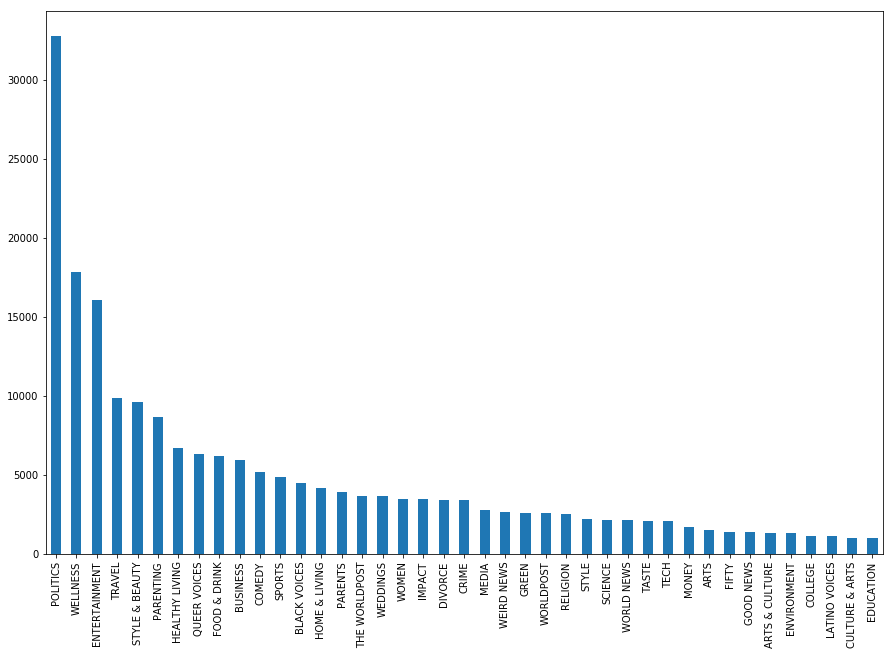

In [24]:
df['category'].value_counts().plot( kind='bar', figsize=(15,10))
plt.show()

In [25]:
print(df['category'].unique())

['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'WELLNESS' 'PARENTING' 'HOME & LIVING' 'STYLE & BEAUTY' 'DIVORCE'
 'WEDDINGS' 'FOOD & DRINK' 'MONEY' 'ENVIRONMENT' 'CULTURE & ARTS']


Going to combine 'THE WORLDPOST' with 'WORLDPOST' since they are basically the same thing.

In [3]:
df.category = df.category.map(lambda x: 'WORLDPOST' if x== 'THE WORLDPOST' else x)

In [27]:
df.describe()

,authors,category,date,headline,link,short_description
count,200853,200853,200853,200853,200853,200853
unique,27993,40,2309,199344,200812,178353
top,,POLITICS,2013-01-17 00:00:00,Sunday Roundup,https://www.huffingtonpost.comhttp://www.purpo...,
freq,36620,32739,100,90,2,19712
first,NaN,NaN,2012-01-28 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2018-05-26 00:00:00,NaN,NaN,NaN


## Preparing the Data
Since we're working with text data, we'll still need to do some basic preprocessing and tokenize our data. You'll notice from the sample of the data above that two different columns contain text data--headline and short_description. The more text data our Word2Vec model has, the better it will perform. Therefore, we'll want to combine the two columns before tokenizing each comment and training our Word2Vec model.

In [94]:
# takes a while, a lot of data...
target = df.category
df['combined_text'] = df.headline + ' ' +  df.short_description
data = df['combined_text'].map(word_tokenize).values

## Loading A Pretrained GloVe Model
I will be loading the pretrained weights from GloVe (short for Global Vectors for Word Representation) from the Stanford NLP Group. These are commonly accepted as some of the best pre-trained word vectors available, and they're open source. Because of machine limitations, I will only be using the smallest(still containing 100-dimensional word vectors for 6 billion words!).

### Getting the Total Vocabulary
Although our pretrained GloVe data contains vectors for 6 billion words and phrases, we don't need all of them. Instead, we only need the vectors for the words that appear in our dataset. If a word or phrase doesn't appear in our dataset, then there's no reason to waste memory storing the vector for that word or phrase.

This means that we need to start by computing the total vocabulary of our dataset. We can do this by adding every word in the dataset into a python set object. This is easy, since we've already tokenized each comment stored within data.


In [36]:
total_vocabulary = set(word for headline in data for word in headline)

In [37]:
len(total_vocabulary)
print("There are {} unique tokens in our dataset.".format(len(total_vocabulary)))

There are 279 unique tokens in our dataset.


In [8]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

we now have all of the words and their corresponding vocabulary stored within our dictionary, glove, as key/value pairs.
let's double check
It's probably safe to assume that the word 'senator' will be mentioned in at least one news headline, so let's get the vector for it.

In [9]:
glove['senator']

array([-0.39334  ,  0.18748  ,  0.6471   ,  0.14527  ,  0.15966  ,
        1.1369   , -0.79629  ,  0.35415  , -0.56611  , -1.0419   ,
       -1.5981   , -0.043776 ,  0.13376  , -0.08937  , -0.29572  ,
       -0.9005   , -0.12758  ,  0.020343 ,  0.43953  , -0.33088  ,
       -0.79181  ,  0.0078458,  0.25937  , -0.46204  ,  0.5987   ,
       -2.6559   ,  0.23042  , -0.26325  , -0.63301  ,  0.39607  ,
        1.0315   , -0.43104  , -1.1923   , -0.73129  , -0.038077 ,
       -1.1653   , -0.42326  ,  0.78656  , -0.20375  , -0.71893  ,
       -0.53437  ,  1.1682   , -0.87608  , -0.21386  , -0.45835  ,
        0.28739  , -1.1319   , -0.35848  , -0.0080362,  1.5094   ],
      dtype=float32)

The next step is to combine all the vectors for a given headline into a Mean Embedding by finding the average of all the vectors in that headline.

### Creating Mean Word Embeddings

In [10]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # It can't be used in a sklearn Pipeline. 
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [11]:
rf =  Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=True))])

svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])

lr = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [12]:
models = [('Random Forest', rf),
          ("Support Vector Machine", svc),
          ("Logistic Regression", lr)]

In [36]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.0s finished
/Users/nick/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/nick/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureW

In [37]:
scores

[('Random Forest', 0.3040862473652662),
 ('Support Vector Machine', 0.31789813859395244),
 ('Logistic Regression', 0.3186251591420255)]

These scores may seem pretty low, but remember that there are 40 (after some feature engineering) possible categories that headlines could be classified into. This means the naive accuracy rate (random guessing) would achieve an accuracy of just over 0.025!(2.5%) Our models have plenty of room for improvement, but they do work!

I think it is also worth mentioning that there was not much difference in scores when I ran 20% of data set through the model VS the entire dataset, except that it took much longer (almost 3 hours).

### Deep Learning (With Word Embeddings)

First, I import everything we'll need from Keras.

In [95]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

Then convert our labels to a one-hot encoded format.

In [96]:
y = pd.get_dummies(target).values

Now, we'll preprocess our text data. To do this, we start from the step where we combined the headlines and short description. We'll then use Keras's preprocessing tools to tokenize each example, convert them to sequences, and then pad the sequences so they're all the same length.

Note how during the tokenization step, we set a parameter to tell the tokenizer to limit our overall vocabulary size to the 20000 most important words.

In [47]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(df.combined_text))
list_tokenized_headlines = tokenizer.texts_to_sequences(df.combined_text)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

Now, we'll construct our neural network. Notice how the Embedding Layer comes second, after the input layer. In the Embedding Layer, we specify the size we want our word vectors to be, as well as the size of the embedding space itself. The embedding size we specified is 128, and the size of the embedding space is best as the size of the total vocabulary that we're using. Since we limited the vocab to 20000, that's the size we choose for the embedding layer.

Once our data has passed through an embedding layer, we feed this data into an LSTM layer, followed by a Dense layer, followed by output layer. We also add some Dropout layers after each of these layers, to help fight overfitting.

Our output layer is a Dense layer with 40 neurons, which corresponds to the 40 possible classes in our labels. We set the activation function for this output layer to 'softmax', so that our network will output a vector of predictions, where each element's value corresponds to the percentage chance that the example is the class that corresponds to that element, and where the sum of all elements in the output vector is 1.

In [15]:
embedding_size = 128
input_ = Input(shape=(100,))
x = Embedding(20000, embedding_size)(input_)
x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
# There are 40 different possible classes, so we use 41 neurons in our output layer
x = Dense(40, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)

Once we have designed our model, we still have to compile it, and provide important parameters such as the loss function to use ('categorical_crossentropy', since this is a mutliclass classification problem), and the optimizer to use.

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

We quickly check the summary of the model to see what our model looks like, and make sure the output shapes line up with what we expect.

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 25)           15400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

Finally, we can fit the model by passing in the data, our labels, and setting some other hyperparameters such as the batch size, the number of epochs to train for, and what percentage of the training data to use for validation data.

In [19]:
model.fit(X_t, y, epochs=10, batch_size=32, validation_split=0.1)

Train on 36153 samples, validate on 4018 samples
Epoch 1/10
36153/36153 [==============================] - 107s 3ms/step - loss: 2.1910 - accuracy: 0.4193 - val_loss: 2.1853 - val_accuracy: 0.4403
Epoch 2/10
36153/36153 [==============================] - 106s 3ms/step - loss: 1.9835 - accuracy: 0.4620 - val_loss: 2.1801 - val_accuracy: 0.4495
Epoch 3/10
36153/36153 [==============================] - 108s 3ms/step - loss: 1.8219 - accuracy: 0.4940 - val_loss: 2.2572 - val_accuracy: 0.4632
Epoch 4/10
36153/36153 [==============================] - 107s 3ms/step - loss: 1.6947 - accuracy: 0.5248 - val_loss: 2.2839 - val_accuracy: 0.4567
Epoch 5/10
36153/36153 [==============================] - 107s 3ms/step - loss: 1.5843 - accuracy: 0.5446 - val_loss: 2.3524 - val_accuracy: 0.4562
Epoch 6/10
36153/36153 [==============================] - 143s 4ms/step - loss: 1.5039 - accuracy: 0.5610 - val_loss: 2.4697 - val_accuracy: 0.4512
Epoch 7/10
36153/36153 [==============================] - 108s 

### Sequence Models, better known as Recurrent Neural Networks

The hallmark of Recurrent Neural Networks is that they are used to evaluate Sequences of data, rather than just individual data points. All text data is sequence data by default--a sentance only makes sense when it's words are in the proper order. Recurrent Neural Networks (RNN) can take in text as full sequences of words, from a single sentence up to an entire document or book! Because of this, they do not suffer the same loss of information that comes from a traditional Bag-of-Words vectorization approach.

In [81]:
import keras
from keras.layers import LSTM, GRU, Dense, GlobalMaxPool1D, Embedding, Dropout
from keras.preprocessing import text, sequence
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)
import pandas as pd

In [82]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(data))
list_tokenized_train = tokenizer.texts_to_sequences(data)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=100)

In [46]:
# LSTM Model

lstm_model = Sequential()
lstm_model.add(Embedding(20000, 128))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(GlobalMaxPool1D())
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(40, activation='softmax'))

#### Compilation Parameters
Now that we've built our model, we still need to compile it.

In [49]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Before we train our model, let's take a look at what it looks like, and see how many trainable parameters it has.

In [50]:
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 50)          35800     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 40)               

#### Training Our Model

Now that we have preprocessed our data, created our model, and compiled it, we're ready for the moment of truth--training!

In [51]:
lstm_model.fit(X_t, y, epochs=5, batch_size=32, validation_split=0.1)


Train on 36153 samples, validate on 4018 samples
Epoch 1/5
36153/36153 [==============================] - 124s 3ms/step - loss: 3.0242 - accuracy: 0.2319 - val_loss: 2.5963 - val_accuracy: 0.3218
Epoch 2/5
36153/36153 [==============================] - 120s 3ms/step - loss: 2.4291 - accuracy: 0.3656 - val_loss: 2.2571 - val_accuracy: 0.4019
Epoch 3/5
36153/36153 [==============================] - 122s 3ms/step - loss: 2.0642 - accuracy: 0.4493 - val_loss: 2.1372 - val_accuracy: 0.4530
Epoch 4/5
36153/36153 [==============================] - 121s 3ms/step - loss: 1.8090 - accuracy: 0.5079 - val_loss: 2.1312 - val_accuracy: 0.4771
Epoch 5/5
36153/36153 [==============================] - 122s 3ms/step - loss: 1.6373 - accuracy: 0.5461 - val_loss: 2.2266 - val_accuracy: 0.4798


#### Building Our GRU Model

Now that we have a benchmark for how an LSTM model performs, let's build the exact same model, but with GRU() cells instead of LSTM() cells!

In [53]:
# GRU Model

gru_model = Sequential()
gru_model.add(Embedding(20000, 128))
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(GlobalMaxPool1D())
gru_model.add(Dropout(0.5))
gru_model.add(Dense(50, activation='relu'))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(40, activation='softmax'))

Now, compile the model with the same parameters we did for the first network.

In [54]:
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Now, let's look at a .summary() of our GRU model, and see if it has more or less total trainable parameters than our LSTM model.

In [55]:
gru_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru_2 (GRU)                  (None, None, 50)          26850     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 50)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 40)               

Finally, train our GRU model using the same parameters as we did for our LSTM model.

In [56]:
gru_model.fit(X_t, y, epochs=5, batch_size=32, validation_split=0.1)

Train on 36153 samples, validate on 4018 samples
Epoch 1/5
36153/36153 [==============================] - 123s 3ms/step - loss: 3.0236 - accuracy: 0.2337 - val_loss: 2.5191 - val_accuracy: 0.3606
Epoch 2/5
36153/36153 [==============================] - 122s 3ms/step - loss: 2.3969 - accuracy: 0.3837 - val_loss: 2.2261 - val_accuracy: 0.4216
Epoch 3/5
36153/36153 [==============================] - 124s 3ms/step - loss: 2.0571 - accuracy: 0.4559 - val_loss: 2.0933 - val_accuracy: 0.4632
Epoch 4/5
36153/36153 [==============================] - 124s 3ms/step - loss: 1.8342 - accuracy: 0.5050 - val_loss: 2.0682 - val_accuracy: 0.4769
Epoch 5/5
36153/36153 [==============================] - 122s 3ms/step - loss: 1.6458 - accuracy: 0.5453 - val_loss: 2.1333 - val_accuracy: 0.4843


Both the LSTM and GRU models performed about the same on this particular dataset. That is to say that they both did exceptionally well. After only 5 epochs, with only a small fraction of the entire dataset (machine constraints) they where both able to reach accuracy scores of nearly 55%!

### Bidirectional Sequence Models

A Bidirectional RNN is just like a regular RNN, but with a twist--half of the neurons start by at the beginnig of the data and work towards the end one step at a time, while the other half start at the end of the data and work towards the beginning at the same pace. Neat!

In [97]:
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D

In [98]:
#  This cell takes a little while to run!
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(data))
list_tokenized_train = tokenizer.texts_to_sequences(data)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=100)

In [99]:
embedding_size = 128
input_ = Input(shape=(100,))
x = Embedding(30000, embedding_size)(input_)
x = Bidirectional(LSTM(25, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(40, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(40, activation='sigmoid')(x)

model = Model(inputs=input_, outputs=x)

In [100]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now, let's take a look at the model we've created. In the cell below.

In [101]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 100, 128)          3840000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 50)           30800     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 50)                0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 40)                2040      
_________________________________________________________________
dropout_22 (Dropout)         (None, 40)                0   

In [102]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [103]:
checkpoints_path = 'weights_base.best.hdf5'
checkpoint = ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [104]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25)

In [107]:
callbacks = [checkpoint, early_stopping]

In [108]:
# a Bidirectional LSTM Network
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1, callbacks=callbacks)

Train on 36153 samples, validate on 4018 samples
Epoch 1/2
36153/36153 [==============================] - 176s 5ms/step - loss: 0.1008 - accuracy: 0.9763 - val_loss: 0.0875 - val_accuracy: 0.9770

Epoch 00001: val_loss improved from inf to 0.08749, saving model to weights_base.best.hdf5
Epoch 2/2
36153/36153 [==============================] - 182s 5ms/step - loss: 0.0905 - accuracy: 0.9771 - val_loss: 0.0814 - val_accuracy: 0.9774

Epoch 00002: val_loss improved from 0.08749 to 0.08138, saving model to weights_base.best.hdf5


Validation accuracy of over 97.7% when trained on only 20% of the data! I think it is pretty safe to say that this model works well.



### Summary

- I did achieve some level of success with traditional machine learning models. Using pre_trained weights to help speed things up I was able to achieve an accuracy score of a little over 30% for Random Forrest, Logistic Regression, and Support Vector Machine(SVM) respectively. I know if I spent more time playing around with the various weights and parameters, I could have gotten a bit more performance from them, but these were still very time consuming, and I knew that deep learning, and Recurrent Neural Networks were going to be strongest contenders.


- My traditional deep learning classification model was a much stronger (and more realistic) right out of the gate. Without having to do much tuning, and still using 20% of the entire dataset (which still took a while) my model was able to achieve after only 10 epochs a training accuracy of over 60% with a Validation accuracy of nearly 50%. At this point, I was already starting to see some sighns of overtraining, as my training score was still slowly getting better, but my Validation score was strting to fall off a bit. I am confident that even keeping with most of my parameters, using more of the dataset, and making some small adjustments to way I preprocessed my data, I could still get a bit more performance out of that type of model. However, this type of fine tuning is still very time (computational and otherwise) consuming, and I knew I had likely saved the best models for last. 


- When it came time for running the data through a Recurrent Neural Network, I knew I was finally making some real strides. Not that the previous models had not performed admirably, they simply were not the best tool for the job. Both my Long Short Term Memory Cells (LSTU) and Gated Recurrent Units (GRU) models performed nearly as well as one another, which was makedly better than my traditional deep neural network. Because of the way these models work, they are more computationally expensive than my previous model, so again, using only 20% of the dataset, and after only 5 epochs each (half as many) both models where already about to overtake the previous benchmark for training accuracy having scores of well over 50%, but with much stronger validation accuracy. Evan after only 5 iterations though the network, they already Validation accuracy of nearly 50%. While I am confident these models would have only continued to grow stronger with more data and more iterations (to a point), I still had my "ACE" up my sleeve, and was ready to see how it performed.


- My Bidirectional Sequence Model did amazingly well! With a Validation accuracy of over 97.7% when trained on only 20% of the data! I think it is pretty safe to say that this model all those who came before it. While every model I used on this dataset did progressively better than previous (more simple) models, this particular model is in a class all it's own. I admit that I worked through these various model types in the order that I assumed would get progressively stronger results, but I am plesantly surprised at how strongly this Bidirectional Sequence Model worked. unfortunetly, my old macbook is getting on in years, so I had to pic and choose carefully what to ask of it. doing only 2 epochs of 20% of the data set still took a while to train.... that being said, the model was still getting stronger with each iteration. I am confident that had I ran the entire dataset with 20 or more epochs(on a better computer), I could achieve an accuracy score of well over 98%, and that before playing with all the tunable parameters.

### Future Work

- Continue collecting and adding to the data (always).

- Try some different preprocessing techniques on the data before modeling, there are large variety of way to preprocess and "normalize" the data before modeling, I only touched on a few.

- Continue playing around with the many (many) tunable parameters of the models I am working with, not only to see if it improves the models performance, but alos to gain more insight about whats going on "under the hood" so to speak, and get more intuition about whats happening with the underlying data. 